In this lab we will study the initial approaches in the context of multiagent systems based on game theory. Mainly the concept of Nash equilibria including repeated games.


# Installation
For this lab we will only need numpy. The toolbox nashpy has already several algorithms implemented and allows to verify some of the results.

In [19]:
%%capture
#nashpy toolbox
%pip install nashpy
%pip install matplotlib
#Knight, V., & Campbell, J. (2018). Nashpy: A Python library for the computation of Nash equilibria. Journal of Open Source Software, 3(30), 904.
#https://nashpy.readthedocs.io/en/stable/text-book/index.html
#https://nashpy.readthedocs.io/en/stable/

import nashpy as nash
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# @title Define Games
#
# We can use the toolbox to define some standard games.
import warnings

Games = {}
A = np.array([[1, -1], [-1, 1]])
Games['Matching_pennies'] = nash.Game(A)

A = np.array([[-1, 1], [1, -1]])
Games['UnMatching_pennies'] = nash.Game(A)

A = np.array([[1, 3], [0, 2]])
B = np.array([[1, 0], [3, 2]])
Games['Prisioner_dilema'] = nash.Game(A,B)

A = np.array([[-2, -2], [6, 0]])
B = np.array([[0, 6], [3, 3]])
Games['Hawk-Dove'] = nash.Game(A,B)

A = np.array([[0,-1,1],[1,0,-1],[-1,1,0]])
Games['Rock-Paper-Scissor'] = nash.Game(A)


# Activity 1 - Nash equilibria
For each of the previous games verify if a Nash equilibria exists in pure strategies.


In [24]:
#Compute pure Nash equilibria
def findPureNash(g):
    nasheq = []
    
    # Get all Nash equilibria
    equilibria = g.support_enumeration()
    
    # Loop over each equilibrium to check if it's a pure strategy (i.e., probabilities are either 0 or 1)
    for eq in equilibria:
        # Check if the strategies are pure (no mixed strategies)
        if np.allclose(eq[0], np.round(eq[0])) and np.allclose(eq[1], np.round(eq[1])):
            nasheq.append(eq)
    
    return nasheq

for kk in Games.keys():
    g = Games[kk]
    ret = findPureNash(g)
    if ret:
        print(kk, "Pure nash equilibria  ", ret)
    else:
        print(kk, "has no pure NE")



Matching_pennies has no pure NE
UnMatching_pennies has no pure NE
Prisioner_dilema Pure nash equilibria   [(array([1., 0.]), array([1., 0.]))]
Hawk-Dove Pure nash equilibria   [(array([0., 1.]), array([1., 0.])), (array([0., 1.]), array([0., 1.]))]
Rock-Paper-Scissor has no pure NE


You can verify your solution with the following code, that uses the various methods of the toolbox, to compute the Nash equilibria.

In [25]:
# game solutions based on Nashpy

for kk in Games.keys():
    g = Games[kk]

    if g.zero_sum:
        a = g.linear_program()
    else:
        a = g.vertex_enumeration()
        #b = g.support_enumeration()
    print(kk,"\n Nash equilibria\n",list(a))

    # Ficticious Play
    np.random.seed(0)
    iterations = 5000
    play_counts = g.fictitious_play(iterations=iterations)
    play_counts=np.array(list(play_counts))
    print(" ficticious play\n", play_counts[-1,:,:]/(play_counts.shape[0]-1))


Matching_pennies 
 Nash equilibria
 [array([0.5, 0.5]), array([0.5, 0.5])]
 ficticious play
 [[0.4966 0.5034]
 [0.4926 0.5074]]
UnMatching_pennies 
 Nash equilibria
 [array([0.5, 0.5]), array([0.5, 0.5])]
 ficticious play
 [[0.499  0.501 ]
 [0.4916 0.5084]]
Prisioner_dilema 
 Nash equilibria
 [(array([1., 0.]), array([1., 0.]))]
 ficticious play
 [[1.000e+00 0.000e+00]
 [9.998e-01 2.000e-04]]
Hawk-Dove 
 Nash equilibria
 [(array([0., 1.]), array([0., 1.])), (array([0., 1.]), array([1., 0.]))]
 ficticious play
 [[2.000e-04 9.998e-01]
 [0.000e+00 1.000e+00]]
Rock-Paper-Scissor 
 Nash equilibria
 [array([0.33333333, 0.33333333, 0.33333333]), array([0.33333333, 0.33333333, 0.33333333])]
 ficticious play
 [[0.3376 0.3276 0.3348]
 [0.3238 0.343  0.3332]]


# Activity 2
Nash equilibria is in many cases not the best for both players and other strategies have been proposed. Define 3 strategies, always Nash, Tit-for-Tat (repeat the action of the other player), or Tit-for-Two-Tats (defect only after two defects). Make games between all the types of agents. What is the best strategy?

In [26]:
strat = ['nash','t4t','t42t']
N = 100
g = Games['Prisioner_dilema']

# player - player number 0/1
# P - list with the previous plays
# strat - strategy of the player ['nash','t4t','t42t']
# it should return a pure strategy as a vector, e.g. [1,0] to choose the first action
def play(player, P, strat):
    opponent = 1 - player       # index of the other player

    # Decide which action index we will take (0 = cooperate, 1 = defect)
    if strat == "nash":
        # Always play the one‑shot Nash equilibrium (Defect)
        action = 1

    elif strat == "t4t":
        # Cooperate on the very first move, then copy the opponent's last move
        action = P[-1][opponent] if P else 0

    elif strat == "t42t":
        # Defect only if the opponent defected in BOTH of the last two rounds
        if len(P) >= 2 and P[-1][opponent] == 1 and P[-2][opponent] == 1:
            action = 1          # punish after two consecutive defections
        else:
            action = 0          # otherwise cooperate
    else:
        raise ValueError(f"Unknown strategy: {strat}")

    # Convert the chosen action index into a pure‑strategy vector
    return [1, 0] if action == 0 else [0, 1]


for strat0 in strat:
    for strat1 in strat:
        P = [[np.random.randint(0,2),np.random.randint(0,2)]]
        R = []
        for nn in range(0,N):
            p0 = play( 0, P, strat0)
            p1 = play( 1, P, strat1)
            P.append([p0.index(1),p1.index(1)])
            r = g[p0,p1]
            R.append([r[0],r[1]])
        print(strat0,strat1,np.sum(np.array(R),axis=0))

nash nash [200 200]
nash t4t [200 200]
nash t42t [196 202]
t4t nash [200 200]
t4t t4t [150 150]
t4t t42t [100 100]
t42t nash [201 198]
t42t t4t [100 100]
t42t t42t [100 100]


# Questions
### Is playing the NE always better?

Not in the iterated Prisoner’s Dilemma. Against itself, “always-defect” (the one-shot NE) locks both players into mutual defection at payoff 2 per round (so over 100 rounds you saw 200 each). But mutual cooperation (e.g. TFT vs TFT) yields 3 × 100 = 300 each, which is strictly higher. In head-to-head comparisons your “nash” player never gets a better long-run total than its opponent—and often does worse in aggregate than cooperative strategies. So while NE is “safe” in the one-shot sense, in repeated play it is outperformed by reciprocal strategies that sustain cooperation.

### Are these strategies meaningfull in all games? How do the different strategies result in the different games?

“TFT” and “TF2T” are tailor-made for alternatives between “cooperate” and “defect,” and rely on a notion of “punish a defection.” In zero-sum games (e.g. Matching Pennies) there is no cooperative payoff to sustain, so copying your opponent simply invites exploitation or endless cycling. In coordination games (e.g. Hawk–Dove) you’d need to reinterpret “cooperate/defect” as “hawk/dove,” and a pure-punishment rule can backfire (two hawks fight, two doves yield low payoff). In short, you must adapt the logic of TFT/TF2T to the payoff structure: whenever the game no longer rewards mutual “cooperation,” these strategies either collapse to random cycling or get exploited.

### Which of the previous strategies is more robust to the shaking hand problem, i.e. when an agent wants to make an action but - by mistake - does another? How can you change the code to verify it?

If each move has a small probability ε of being flipped—i.e. you intend to cooperate but accidentally defect—then TFT immediately retaliates on the next round and can spiral into “grim cycles.” TF2T, however, only punishes after two consecutive defections, so a single mistaken defect is forgiven, and cooperation rapidly resumes. Hence:

Most robust: TF2T

Least robust: TFT (pays no forgiveness)

# Activity 3
Similar to game theory, Evolutionary stable strategies explain how the strategy of a complete species can evolve. The `g.replicator_dynamics` function for the toolbox can compute this as in this code.
Try to replicate the code in the following cell.
Answer the following questions. Which games have an ESS? How does it related with the existing Nash Equilibria? What are the properties of the games where there is not an ESS?

[Evolutionary stable strategies](https://nashpy.readthedocs.io/en/v0.0.22/reference/replicator-dynamics.html)

[0.50504347 0.20452871 0.29042782]
[9.99591566e-01 4.08434177e-04]


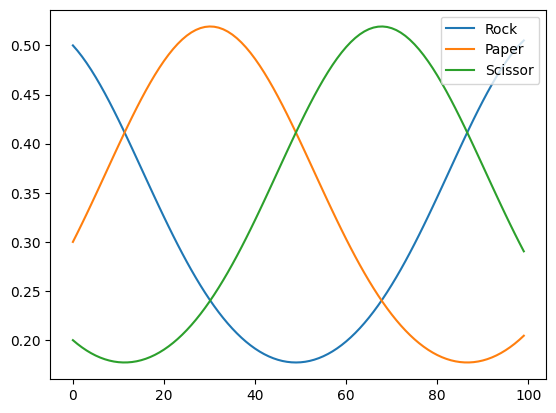

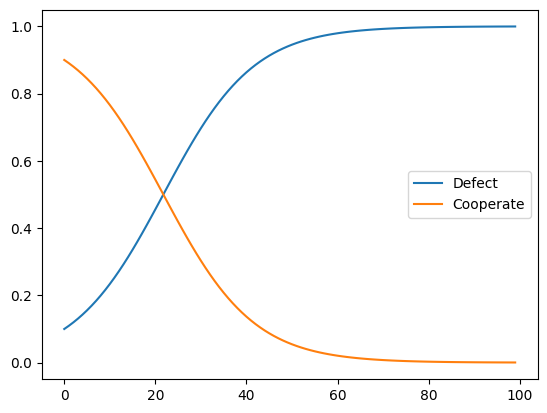

In [27]:
# @title ESS
import matplotlib.pyplot as plt

g = Games['Rock-Paper-Scissor']
y0 = np.array([0.5, 0.3, 0.2])

nA = g.payoff_matrices[0].shape[0]

mut = 0.0
mutation = np.eye(nA)*(1-mut)+(1-np.eye(nA))*mut/(nA-1)

play_counts = g.replicator_dynamics(y0=y0, timepoints=np.linspace(0, 10, 100)
                                        ,mutation_matrix=mutation)
print(play_counts[-1,:])
plt.plot(play_counts)
plt.legend(['Rock','Paper','Scissor'])


g = Games['Prisioner_dilema']
y0 = np.array([0.1,0.9])

nA = g.payoff_matrices[0].shape[0]

mut = 0.0
mutation = np.eye(nA)*(1-mut)+(1-np.eye(nA))*mut/(nA-1)

play_counts = g.replicator_dynamics(y0=y0, timepoints=np.linspace(0, 10, 100)
                                        ,mutation_matrix=mutation)
print(play_counts[-1,:])
plt.figure()
plt.plot(play_counts)
plt.legend(['Defect','Cooperate'])


In the following cell we compute explicitly the dynamics.

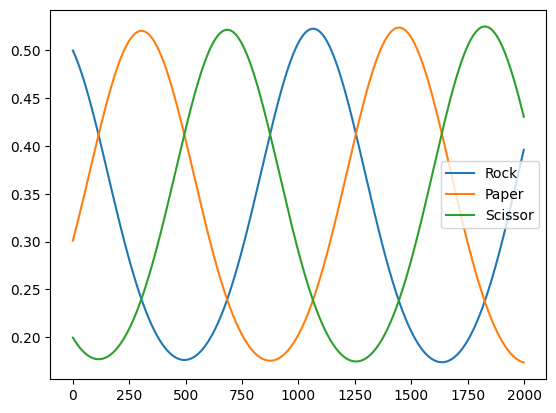

In [28]:
g = Games['Prisioner_dilema']
g = Games['UnMatching_pennies']
g = Games['Rock-Paper-Scissor']

th = np.array([0.5, 0.3, 0.2])
dt = 0.01
TH = []

def dynreplicator(g,th):
    # todo
    va = g.payoff_matrices[0]@th
    v = th@g.payoff_matrices[0]@th

    dth = th * (va-v)

    return dth

for ii in np.arange(0,20,dt):

    dth = dynreplicator(g,th)
    th = np.clip(th + dth * dt, 0, 1)
    th /= np.sum(th)
    TH += [th]
    #print(th,va,v,dt)
    #plt.figure()
plt.plot(TH)
plt.legend(['Rock','Paper','Scissor'])

### Which games have an ESS?

1. **Prisoner’s Dilemma**

   * **ESS:** pure “defect” is the only stable state.
   * **Relation to NE:** it coincides with the unique one-shot Nash equilibrium (D,D).

2. **Hawk–Dove**

   * **ESS:** a *mixed* proportion of Hawks to Doves (specifically the point where payoffs of Hawk and Dove balance).
   * **Relation to NE:** that mixed point is exactly the symmetric mixed Nash equilibrium.

3. **Matching Pennies** & **Rock–Paper–Scissors**

   * **No ESS:** replicator dynamics cycle endlessly around the mixed‐strategy Nash equilibrium without settling.
   * **Property:** zero-sum or “cyclic best responses” so no attractor; the symmetric NE is unstable under small perturbations.

4. **Unmatching Pennies**

   * Similar to Matching Pennies: **no ESS**, cyclic play.

### Why some games lack an ESS

* **Zero-sum structure:** gains to one player equal losses to the other, so there’s no point of rest where everyone’s payoff is simultaneously maximized or at least not exploitable.
* **Cyclic dominance:** each pure strategy is beaten by another, leading to rock–paper–scissors–style intransitivity.
* **No stable fixed point:** the only symmetric Nash equilibrium is a mixed strategy sitting at the center of the simplex, but it’s a *center* rather than a sink, so trajectories revolve around it without convergence.
